In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
#import modulocascada as cas

from matplotlib import colors
#from solvers2D  import gauss_seidel, sor, redblack,gaussseidel
#from coeficientes2D import cofD_2D
#from redes2D  import red_nodal_2D_u
#from imprimeydibuja2D import imprime_matriz_2D
import math


# Definicion de módulos

In [26]:
# función: Imprimir en pantalla la matriz (Nx,Ny)
def imprime_matriz_2D(Nx, Ny, a, nombre):
    # Printing a 2D matrix

    print(f"--- nodos en x:{Nx}- nodos en y: {Ny}- matriz {nombre}-----")
    for i in range(Ny ):
        for j in range(Nx ):
            print(f"{a[i][j]:.2f} ", end="")
        print()


In [27]:

# función: Conductividad equivalente entre celdas
''' 
Retorna la conductividad eficiente armonica. Si los valores de las resistencias son nulas
tiene un valor mínimo de tolerancia 1e-8
'''
def kf(k1, k2):
    denom=(k1 + k2)
    if (k1==0) and (k2==0):
        denom += 1e-5
    return (2. * k1 * k2) / denom


In [28]:

# función: Matriz discreta de la Ecuación de Laplace
def cofD_2D(Nx, Ny, dx, dy, ap0, x, y, kn, u, Sc, Sp):
    '''Matriz de coeficientes para la ecuacion de difusion
       calcula para los nodos internos.
       Deben ser modificados para incluir las condiciones de borde
       Parametros:
       Nx,Ny= cantidad de nodos en eje x e y- incluidos los BORDES
       kn= matriz con la conductividad termica en cada nodo
       Sc,Sp= matriz de los terminos fuentes constante y lineal
       '''

    # Coefficients for the control volumes
    ae  = np.zeros((Ny , Nx) ,dtype=float)
    ao  = np.zeros((Ny , Nx ),dtype=float)
    an  = np.zeros((Ny , Nx) ,dtype=float)
    ass = np.zeros((Ny , Nx ),dtype=float)
    ap  = np.zeros((Ny , Nx ),dtype=float)
    b   = np.zeros((Ny , Nx ),dtype=float)


    for i in range(1, Ny -1):
        for j in range(1, Nx - 1):
            ae[i][j] = (kf(kn[i][j], kn[i][j + 1]) * dy) / (x[j + 1] - x[j])
            ao[i][j] = (kf(kn[i][j], kn[i][j - 1]) * dy) / (x[j] - x[j - 1])
            an[i][j] = (kf(kn[i][j], kn[i + 1][j]) * dx) / (y[i + 1] - y[i])
            ass[i][j] = (kf(kn[i][j], kn[i - 1][j]) * dx) / (y[i] - y[i - 1])

            apaux = ao[i][j] + ae[i][j] + an[i][j] + ass[i][j]
            ap[i][j] = -(apaux + ap0 - Sp[i][j] * dx * dy)
            b[i][j] = -(ap0 * u[i][j] + Sc[i][j] * dx * dy)

    return ae, ao, an, ass, ap, b


In [29]:
#función: Resolución por Gauss- Seidel
def gaussseidel(Nx, Ny, ae, ao, an, ass, ap, b, u,
                tol=1e-8, maxiter=None,
                criterion='residual',   # 'residual' or 'delta'
                check_every=1,          # cada cuantas iteraciones computar residuo
                verbose=False):
    """
    Gauss-Seidel 2D con criterio de parada configurable.

    Parametros:
      Nx, Ny: numero de celdas internas (uso índices 1..Nx, 1..Ny)
      ae, ao, an, ass, ap, b, u: arrays numpy de forma (Ny+2, Nx+2)
         (se asume que los "bordes" 0 y N+1 están disponibles como ghost/bc)
      tol: tolerancia relativa (por defecto 1e-8)
      maxiter: maximo de iteraciones (por defecto Nx*Ny)
      criterio: 'residual' (por defecto) o 'delta'
      check_every: cada cuantas iteraciones calcular el residual (reduce coste)
      verbose: imprime informacion de progreso

    Retorna:
      u, info donde info es un dict con 'iter', 'final_norm', 'bnorma'
    """

    if maxiter is None:
        maxiter = Nx * Ny

    # Norma de b (infinity norm) en el interior del dominio
    b_interior = b[1:Ny+1, 1:Nx+1] ## CORRECCIÓN N_x+1 , N_x+1 CAMBIO DE SIGNO EN LA SUMA
    bnorm = np.max(np.abs(b_interior))
    if bnorm == 0:
        bnorm = 1.0

    iter_count = 0
    # si usamos 'delta' guardamos una copia previa
    if criterion == 'delta':
        u_old = u.copy()

    final_norm = None

    while True:
        iter_count += 1

        # Barrido de Gauss-Seidel   CORRECCIÓN EN LOS SIGNOS DE LA SUMA DE GAUS
        for i in range(1, Ny+1):
            for j in range(1, Nx+1):
                u[i, j] = ( b[i, j]
                    -ao[i, j] * u[i, j-1] 
                    -ae[i, j] * u[i, j+1]
                    -an[i, j] * u[i+1, j] 
                    -ass[i, j] * u[i-1, j]                   
                ) / ap[i, j]
        # Chequeos y criterios
        if iter_count==1:
            imprime_matriz_2D(Nx+2, Ny+2, u, "primera iteracion u")

        if criterion == 'delta':
            # ||u - u_old||_inf
            diff = np.max(np.abs(u[1:Ny+1, 1:Nx+1] - u_old[1:Ny+1, 1:Nx+1]))
            final_norm = diff
            if verbose:
                print(f"iter {iter_count}, delta_inf = {diff:.3e}")
            if diff < tol or iter_count >= maxiter:
                break
            # actualizar u_old
            u_old[:] = u
            

        else:  # criterio 'residual'
            # calculamos residual cada 'check_every' iteraciones
            if iter_count % check_every == 0 or iter_count == 1:
                # construimos residuo r = b - (A u)
                # Para cada interior (i,j): A u = ap*u - ao*u_left - ae*u_right - an*u_up - a_s*u_down
                Au = (ap[1:Ny+1, 1:Nx+1] * u[1:Ny+1, 1:Nx+1]
                      +ao[1:Ny+1, 1:Nx+1] * u[1:Ny+1, 0:Nx]
                      + ae[1:Ny+1, 1:Nx+1] * u[1:Ny+1, 2:Nx+2]
                      + an[1:Ny+1, 1:Nx+1] * u[2:Ny+2, 1:Nx+1]
                      + ass[1:Ny+1, 1:Nx+1] * u[0:Ny, 1:Nx+1])
                r = b_interior - Au
                rnorm = np.max(np.abs(r))
                final_norm = rnorm
                rel = rnorm / bnorm
                if verbose:
                    print(f"iter {iter_count}, ||r||_inf = {rnorm:.3e}, rel = {rel:.3e}")
                if rel < tol or iter_count >= maxiter:
                    break

        # seguridad: evitar bucle infinito
        if iter_count >= maxiter:
            break

    info = {'iter': iter_count, 'final_norm': float(final_norm), 'bnorma': float(bnorm)}
    if verbose:
        print(f"Gauss-Seidel final: iter={iter_count}, final_norm={final_norm}, bnorm={bnorm}")
    return u, info


In [30]:

def red_nodal_2D_u(Nx, Ny, Lx, Ly):
    ''' 
    Nx, Ny numero total de nodos
     método de Volumenes de control
     Nodos centrados entre caras para Red uniforme
    Observar que no todos los dx,dy son iguales
    '''
    x = np.zeros(Nx)
    y = np.zeros(Ny)
    dx=Lx/(Nx-2)
    dy=Ly/(Ny-2)
    print(dx,dy)
    x = [0] * (Nx )
    y = [0] * (Ny )

    x[0] = 0
    x[1] = dx / 2
    for i in range(2, Nx-1 ):
        x[i] = x[i - 1] + dx
    x[Nx - 1] = x[Nx-2] + (dx / 2)
    print(x)

    y[0] = 0
    y[1] = dy / 2
    for i in range(2, Ny-1 ):
        y[i] = y[i - 1] + dy
    y[Ny -1 ] = y[Ny-2] + (dy / 2)
    print(y)

    return x,dx, y,dy


## Condiciones de Borde de Dirichlet, Newman y Robin

In [7]:
# ===============================================================
# Condición de Borde de Dirichlet: T = T_borde
# ===============================================================
def dirichletCB(Nx, Ny, dx, dy, ap0, x, y, kn, ae, ao, an, ass, ap, b, u, Sc, Sp):

    # ---- Borde Izquierdo j=0 ----
    j = 1
    for i in range(1, Ny - 1):
        b[i][j] = b[i][j] - ao[i][j] * u[i][j - 1]

    # ---- Borde Derecho j=Nx-1 ----
    j = Nx - 2
    for i in range(1, Ny - 1):
        b[i][j] = b[i][j] - ae[i][j] * u[i][j + 1]

    # ---- Borde Inferior i=0 ----
    i = 1
    for j in range(1, Nx - 1):
        b[i][j] = b[i][j] - ass[i][j] * u[i - 1][j]

    # ---- Borde Superior i=Ny-1 ----
    i = Ny - 2
    for j in range(1, Nx - 1):
        b[i][j] = b[i][j] - an[i][j] * u[i + 1][j]

    return ae, ao, an, ass, ap, b


In [8]:
#  Concidiones de borde Dirchlet para nuestro problema
def bordesDirichlet(Nx,Ny,x,dx,y,dy,u,Bo,Be,Bs,Bn):
    # ===============================================================
    # Condicion de borde de Dirichlet oeste y este
   
    #Ny,Nx =u.shape
    if Bo!='-':
        for i in range(0, Ny ):
            u[i][0] = Bo
            
    if Be!='-':
        for i in range(0, Ny ):
            u[i][Nx-1] = Be

    # Condicion de borde de Dirichlet norte y sur
    if Bs!='-':
        for j in range(0, Nx ):
            for i in range(0,Ny):
                if (x[j]<1) and (y[i]<=1) :
                    u[i][j]=Bo
                else :
                    u[0][j] =Bs
    
    if Bn!='-': 
        for j in range(0, Nx ):
            for i in range(0,Ny):
                if (x[j]<1) and (y[i]>=2) :
                    u[i][j]=Bo
                else :
                    u[Ny- 1][j] = Bn
                
    return np.array(u)


In [9]:
# ===============================================================
# Condición de Borde de Neumann: dT/dn = qn / k
# qn es flujo de calor normal (W/m²)
# ===============================================================
def neumannCB(Nx, Ny,x, dx,y, dy, qO ,qE,qS,qN, kn, ae, ao, an, ass, ap, b, u):

    # ----- Borde Oeste (izquierda) -----
    if qO!='-':
        for i in range(1, Ny - 1):
            b[i][1] += qO * dy   # flujo por área

    # ----- Borde Este (derecha) -----
    if qE!='-':
        for i in range(1, Ny - 1):
            b[i][Nx - 2] += qE * dy

    # ----- Borde Sur (abajo) -----
    if qS!='-':
        for j in range(1, Nx - 1):
            if x[j]>=1:
                b[1][j] += qS * dx
            

    # ----- Borde Norte (arriba) -----
    if qN!='-':
        for j in range(1, Nx - 1):
            if x[j]>=1:
                b[Ny - 2][j] += qN * dx

    return ae, ao, an, ass, ap, b


In [10]:
# ===============================================================
# Condición de Borde de Robin Radiativo:
# -k dT/dn = h (T - T_inf)
# ===============================================================
def robinCB(Nx, Ny,x, dx,y, dy, h, Tinf, kn, ae, ao, an, ass, ap, b, u,ro,re,rs,rn):

    # ---- Oeste (izquierda) ----
    if ro!= 0:
        A = dy
        
        for i in range(1, Ny - 1):
            for j in range(1,Nx-1):
                if (x[j]<1) and ((y[i]<1) or (y[i]>2)):
                    ap[i][j] += h * A
                    b[i][j] += h * A * Tinf
                elif (j == 1) and (1<=y[i]<=2):
                    ap[i][j] += h * A
                    b[i][j] += h * A * Tinf

    # ---- Este (derecha) ----
    if re!= 0:
        A = dy
        j = Nx - 2
        for i in range(1, Ny - 1):
            ap[i][j] += h * A
            b[i][j] += h * A * Tinf

    # ---- Sur (abajo) ----
    if rs!= 0:
        A = dx
        i = 1
        for j in range(1, Nx - 1):
            if x[j]<1:
                ap[i][j] += h * A
                b[i][j] += h * A * Tinf

    # ---- Norte (arriba) ----
    if rn!= 0:
        A = dx
        i = Ny - 2
        for j in range(1, Nx - 1):
            if x[j]<1:
                ap[i][j] += h * A
                b[i][j] += h * A * Tinf

    return ae, ao, an, ass, ap, b


# Implementación

## revisar codigo anterior

In [11]:
'''
# Define matrix de condictividad , capacidad calorica  uniforme en toda la malla
def propiedades(Ny , Nx, rhoo,Cpp,kk ):
    # Matriz de conductividades nodales
    k   = np.zeros(  (Ny , Nx) ,dtype=float)
    rho = np.zeros(  (Ny , Nx) ,dtype=float)
    Cp  = np.zeros(  (Ny , Nx) ,dtype=float)
    # Asigancion de la conductividad uniforme
    for i in range(Ny):
        for j in range(Nx):
            k[i][j] = kk

    for i in range(Ny):
        k[i][0] = 0
        k[i][Nx-1] = 0


    for i in range(Ny):
        for j in range(Nx):
            rho[i][j] = rhoo

    for i in range( Ny ):
        for j in range( Nx ):
            Cp[i][j] = Cpp

    return rho,Cp,k
'''

'\n# Define matrix de condictividad , capacidad calorica  uniforme en toda la malla\ndef propiedades(Ny , Nx, rhoo,Cpp,kk ):\n    # Matriz de conductividades nodales\n    k   = np.zeros(  (Ny , Nx) ,dtype=float)\n    rho = np.zeros(  (Ny , Nx) ,dtype=float)\n    Cp  = np.zeros(  (Ny , Nx) ,dtype=float)\n    # Asigancion de la conductividad uniforme\n    for i in range(Ny):\n        for j in range(Nx):\n            k[i][j] = kk\n\n    for i in range(Ny):\n        k[i][0] = 0\n        k[i][Nx-1] = 0\n\n\n    for i in range(Ny):\n        for j in range(Nx):\n            rho[i][j] = rhoo\n\n    for i in range( Ny ):\n        for j in range( Nx ):\n            Cp[i][j] = Cpp\n\n    return rho,Cp,k\n'

In [12]:

'''
def fuente(Nx,Ny,Scc,Spp):
    # Matrices del termino de generacion
    # Aproximacion lineal S(T)=Scc + Spp * T
    Sc = np.zeros((Ny , Nx) ,dtype=float)  # Coordenada al origen
    Sp = np.zeros((Ny , Nx ),dtype=float)  # Pendiente
    # Asignacion de fuente uniforme
    for i in range(Ny ):
        for j in range(Nx ):
            Sc[i][j] = Scc
            Sp[i][j] = Spp
    return Sc,Sp
'''

'\ndef fuente(Nx,Ny,Scc,Spp):\n    # Matrices del termino de generacion\n    # Aproximacion lineal S(T)=Scc + Spp * T\n    Sc = np.zeros((Ny , Nx) ,dtype=float)  # Coordenada al origen\n    Sp = np.zeros((Ny , Nx ),dtype=float)  # Pendiente\n    # Asignacion de fuente uniforme\n    for i in range(Ny ):\n        for j in range(Nx ):\n            Sc[i][j] = Scc\n            Sp[i][j] = Spp\n    return Sc,Sp\n'

In [13]:
'''
def inicialT(Nx, Ny,Tinicial):
    # Condicion inicial uniforme
    u = np.full((Ny , Nx) ,Tinicial,dtype=float)
    return u
'''

'\ndef inicialT(Nx, Ny,Tinicial):\n    # Condicion inicial uniforme\n    u = np.full((Ny , Nx) ,Tinicial,dtype=float)\n    return u\n'

In [14]:


'''
def solucion(Nx, Ny, Lx,Ly, dx,dy,dt, kk,  Scc, Spp,rhoo,Cpp, Tinicial, ntemporal):
    # Evolution temporal
    omega=1.3
    ap0 = (Cpp * rhoo * dx * dy) / dt
    x,dx, y,dy = red_nodal_2D_u(Nx, Ny, Lx, Ly)

    print("x :", x)
    print("y :", y)
    print("\n")
    Sc,Sp=fuente(Nx,Ny,Scc,Spp)

    imprime_matriz_2D(Nx, Ny, Sc,"Sc")
    imprime_matriz_2D(Nx, Ny, Sp,"Sp")

    rho,Cp,k=propiedades(Nx,Ny,rhoo,Cpp,kk)
    #imprime_matriz_2D(Nx, Ny, rho,"rho")
    #imprime_matriz_2D(Nx, Ny, Cp,"Cp")
    imprime_matriz_2D(Nx, Ny, k,"k")


    u = inicialT(Nx, Ny,Tinicial)
    imprime_matriz_2D(Nx, Ny, u, "---- condicion inicial u")
    u = bordesDirichlet(u)
    imprime_matriz_2D(Nx, Ny, u, "---- bordes Dirichlet u")

    ae, ao, an, ass, ap, b = cofD_2D(Nx, Ny, dx, dy, ap0, x, y, k, u, Sc, Sp)
    imprime_matriz_2D(Nx, Ny, ae, "ae")
    imprime_matriz_2D(Nx, Ny, ao,"ao")
    imprime_matriz_2D(Nx, Ny, an,"an")
    imprime_matriz_2D(Nx, Ny, ass,"ass")
    imprime_matriz_2D(Nx, Ny, ap,"ap")


    for ki in range(1, ntemporal + 1):
        # No esta implementado el caso temporal!!!
        print("# Temporal step %d\n" % ki)
        u,info=gaussseidel(Nx-2, Ny-2, ae, ao, an, ass, ap, b,
                           u,tol=1e-8,
                           maxiter=None,criterion='residual',   # 'residual' or 'delta'
                           check_every=1,          # cada cuantas iteraciones computar residuo
                           verbose=True)

        #u=gauss_seidel(Nx, Ny, ae, ao, an, ass, ap, b, u)
        #u=sor(Nx, Ny, omega, ae, ao, an, ass, ap, b, u)
        #u=redblack(Nx, Ny,  ae, ao, an, as_, ap, b, u)
    imprime_matriz_2D(Nx, Ny, u,"solucion final")

    return x,y, u

    """
    return x,y,u

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, u, cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Solution')
    plt.show()
    """
if __name__ == "__main__":

    """
    Conduccion 2D en una placa rectangular. La fuente corresponde a
    una perdida convectiva.
    """
    # Volumenes de control en diferencias finitas 2D

    Nx = 49  # Numero total de nodos
    Ny = 49
    Lx = 1
    Ly = 1            # Longitud del dominio de caculo
    dx = Lx / (Nx-1)
    dy = Ly / (Ny-1)  # tamanio del volumen de control
    dt = 1e10    # Paso de tiempo, grande -> estacionario
    rhoo = 1.0
    Cpp = 1.0
    kk = 1.0           # Conductividad termica
        # Fuente
    Spp = 0
    Scc = 0
    Tinicial=5
    ntemporal=2
    x,y,u = solucion(Nx, Ny, Lx,Ly, dx,dy,dt, kk,  Scc, Spp,rhoo,Cpp, Tinicial, ntemporal)
    imprime_matriz_2D(Nx, Ny, u ,"solucion u")


    cmap = plt.cm.get_cmap("hot")

    image = u
    #plt.imshow(image ,cmap="hot")
    #plt.imshow(image,vmin=0,vmax=100 ,cmap="hot")
    plt.imshow(image,interpolation='bilinear',vmin=0,vmax=100 ,cmap="hot")
    plt.colorbar()
    plt.show()

'''

'\ndef solucion(Nx, Ny, Lx,Ly, dx,dy,dt, kk,  Scc, Spp,rhoo,Cpp, Tinicial, ntemporal):\n    # Evolution temporal\n    omega=1.3\n    ap0 = (Cpp * rhoo * dx * dy) / dt\n    x,dx, y,dy = red_nodal_2D_u(Nx, Ny, Lx, Ly)\n\n    print("x :", x)\n    print("y :", y)\n    print("\n")\n    Sc,Sp=fuente(Nx,Ny,Scc,Spp)\n\n    imprime_matriz_2D(Nx, Ny, Sc,"Sc")\n    imprime_matriz_2D(Nx, Ny, Sp,"Sp")\n\n    rho,Cp,k=propiedades(Nx,Ny,rhoo,Cpp,kk)\n    #imprime_matriz_2D(Nx, Ny, rho,"rho")\n    #imprime_matriz_2D(Nx, Ny, Cp,"Cp")\n    imprime_matriz_2D(Nx, Ny, k,"k")\n\n\n    u = inicialT(Nx, Ny,Tinicial)\n    imprime_matriz_2D(Nx, Ny, u, "---- condicion inicial u")\n    u = bordesDirichlet(u)\n    imprime_matriz_2D(Nx, Ny, u, "---- bordes Dirichlet u")\n\n    ae, ao, an, ass, ap, b = cofD_2D(Nx, Ny, dx, dy, ap0, x, y, k, u, Sc, Sp)\n    imprime_matriz_2D(Nx, Ny, ae, "ae")\n    imprime_matriz_2D(Nx, Ny, ao,"ao")\n    imprime_matriz_2D(Nx, Ny, an,"an")\n    imprime_matriz_2D(Nx, Ny, ass,"ass")\n    

## Condiciones del Problema

In [15]:
E=0.20
Ne=5
Lx=2.+E
Ly=3
p=Ne/E
Nx=int(np.round(Lx*p))
Ny=int(np.round(Ly*p))

#dx = Lx / (Nx-1)
#dy = Ly / (Ny-1)  # tamanio del volumen de control
dt = 1e7    # Paso de tiempo, grande -> estacionario
rhoo = 1.0
cpp = 1.0
T0=35
ntemporal=1
print(f'cantidad de nodos en x:{Nx} \n cantidad de nodos en y:{Ny} \n cantidad de nodos en ahislante:{Ne}')

cantidad de nodos en x:55 
 cantidad de nodos en y:75 
 cantidad de nodos en ahislante:5


In [39]:
#S=np.random.randint(4,5,[Ny,Nx])

x,dx,y,dy=red_nodal_2D_u(Nx,Ny,Lx,Ly)
scc=70
Spp = 0.
Sc=np.array([[np.random.randint(scc-5,scc+5) if a>=2 else 0 for a in x] for b in y])
#imprime_matriz_2D(Nx,Ny,Sc,'FUENTE CONSTANTE')

Sp = np.full((Ny , Nx ),Spp)
#imprime_matriz_2D(Nx,Ny,Sp,'TÉRMINO LINEAL')

kCobre=150
k_aisl=0.30  # conductividad de LANA DE VIDRIO
eps=0.
k=np.array([[kCobre if (1<=a<=2)  else np.random.rand()+kCobre*2 for a in x] for b in y])
for j in range(len(x)):
    for i in range(len(y)):
        if (x[j]<=1) and (1<=y[i]<=2):
            k[i,j]=kCobre
            
        if (x[j]<1) and ((y[i]<1) or (2<y[i])):
            k[i,j]=eps
            
        if (1<=x[j]<=1.5+E) and ((1-E<=y[i]<=1) or (2<=y[i]<=2+E)):
            k[i,j]=k_aisl
        
        if (1.5<=x[j]<=1.5+E) and ((1-E<=y[i]<=2+E)):
            k[i,j]=k_aisl
#imprime_matriz_2D(Nx,Ny,k,'conductividad')

rho=np.array([[rhoo for a in x] for b in y])
#imprime_matriz_2D(Nx,Ny,rho,'Rho')

Cp=np.array([[cpp for a in x] for b in y])
#imprime_matriz_2D(Nx,Ny,Cp,'Calor Especifico')



0.041509433962264156 0.0410958904109589
[0, 0.020754716981132078, 0.06226415094339623, 0.10377358490566038, 0.14528301886792455, 0.1867924528301887, 0.22830188679245284, 0.269811320754717, 0.3113207547169811, 0.35283018867924526, 0.3943396226415094, 0.43584905660377354, 0.4773584905660377, 0.5188679245283019, 0.560377358490566, 0.6018867924528302, 0.6433962264150943, 0.6849056603773584, 0.7264150943396226, 0.7679245283018867, 0.8094339622641509, 0.850943396226415, 0.8924528301886792, 0.9339622641509433, 0.9754716981132074, 1.0169811320754716, 1.0584905660377357, 1.0999999999999999, 1.141509433962264, 1.1830188679245282, 1.2245283018867923, 1.2660377358490564, 1.3075471698113206, 1.3490566037735847, 1.3905660377358489, 1.432075471698113, 1.4735849056603771, 1.5150943396226413, 1.5566037735849054, 1.5981132075471696, 1.6396226415094337, 1.6811320754716979, 1.722641509433962, 1.7641509433962261, 1.8056603773584903, 1.8471698113207544, 1.8886792452830186, 1.9301886792452827, 1.971698113207

C:\Users\reyes\AppData\Local\Temp\ipykernel_30964\1611744901.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hot")


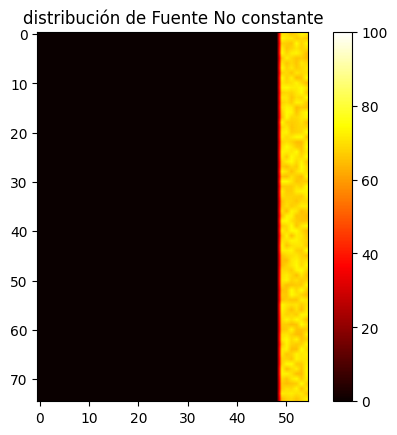

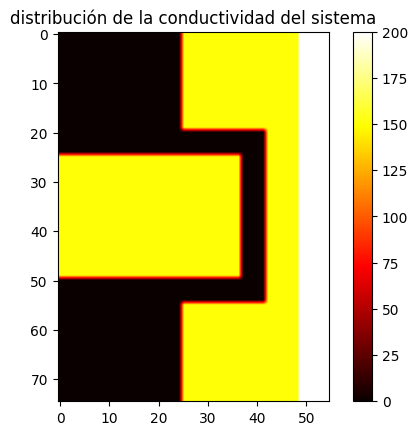

In [40]:
cmap = plt.cm.get_cmap("hot")

image = Sc
image1 = k
#plt.imshow(image ,cmap="hot")
#plt.imshow(image,vmin=0,vmax=100 ,cmap="hot")
plt.imshow(image,interpolation='bilinear',vmin=0,vmax=100 ,cmap="hot")
plt.title('distribución de Fuente No constante')
plt.colorbar()
plt.show()
plt.imshow(image1,interpolation='bilinear',vmin=0,vmax=200 ,cmap="hot")
plt.title('distribución de la conductividad del sistema')
plt.colorbar()
plt.show()

In [36]:
#Tinicial = np.zeros_like(k)
T_amb= 22
dif=15 # deferencia de temp en la parte aislante  
Tinicial=np.array([[T0 if (1<=a<=2)  else np.random.rand()+T_amb  for a in x] for b in y])
for j in range(len(x)):
    for i in range(len(y)):
        #condicion en la temperatura inicial, en el rectangulo sabresaliente de material
        if (x[j]<=1) and (1<=y[i]<=2):
            Tinicial[i,j]=T0
            
        #condicion en la temperatura inicial, en el aislante con una diferencia dif del resto del material   
        if (1<=x[j]<1.5+E) and ((1-E<=y[i]<=1) or (2<=y[i]<=2+E)):
            Tinicial[i,j]=T0-dif
        
        #condicion en la temperatura inicial, en el aislante con una diferencia dif del resto del material
        if (1.5<=x[j]<1.5+E) and ((1-E<=y[i]<=2+E)):  #
            Tinicial[i,j]=T0-dif
            
        #condicion en la temperatura inicial, en la región de la fuente. Temp creciente lineal desde T0 hasta scc
        if (x[j]>2) : 
            r=x[Nx-1]-x[j]
            Tinicial[i,j]=scc*r+ T0*(1-r)
            
            
#Tinicial[k >= 5] = T0
#Tinicial[k < 5] = T0-15
#imprime_matriz_2D(Nx,Ny,Tinicial,'Temperatura inicial')


C:\Users\reyes\AppData\Local\Temp\ipykernel_30964\1375382240.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hot")


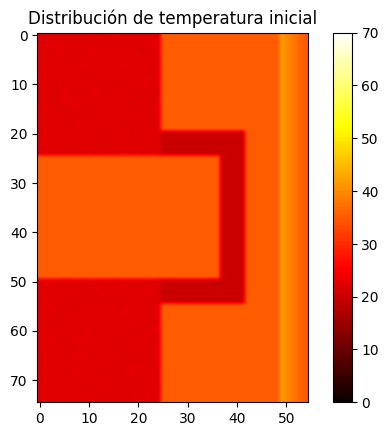

In [37]:
cmap = plt.cm.get_cmap("hot")

image = Tinicial

plt.imshow(image,interpolation='bilinear',vmin=0,vmax=70 ,cmap="hot")
plt.title('Distribución de temperatura inicial')
plt.colorbar()
plt.show()

## Solución

In [20]:
def solucion(Nx, Ny, Lx,Ly,x, dx,y,dy,dt, k, scc, Sc, Sp,rhoo,rho,cpp,Cp, Tinicial, ntemporal,Bo,Be,Bs,Bn,qO ,qE,qS,qN,h, Tinf,ro,re,rs,rn):
    # Evolution temporal
    omega=1.3
    ap0 = (rhoo *cpp * dx * dy) / dt
    #x,dx, y,dy = red_nodal_2D_u(Nx, Ny, Lx, Ly)  INGRESAR MATRICES

    print("x :", x)
    print("y :", y)
    print("\n")
    #Sc,Sp=fuente(Nx,Ny,Scc,Spp)  INGRESAR MATRICES

    #imprime_matriz_2D(Nx, Ny, Sc,"Sc")
    #imprime_matriz_2D(Nx, Ny, Sp,"Sp")

    #rho,Cp,k=propiedades(Nx,Ny,rhoo,Cpp,kk)  INGRESAR MATRICES
    #imprime_matriz_2D(Nx, Ny, rho,"rho")
    #imprime_matriz_2D(Nx, Ny, Cp,"Cp")
    #imprime_matriz_2D(Nx, Ny, k,"k")


    u = Tinicial.copy()
    #imprime_matriz_2D(Nx, Ny, u, "---- condicion inicial u")
    u = bordesDirichlet(Nx,Ny,x,dx,y,dy,u,Bo,Be,Bs,Bn)
    imprime_matriz_2D(Nx, Ny, u, "---- bordes Dirichlet u")
    
    ae, ao, an, ass, ap, b = cofD_2D(Nx, Ny, dx, dy, ap0, x, y, k, u, Sc, Sp)
    #imprime_matriz_2D(Nx, Ny, ae, "ae")
    #imprime_matriz_2D(Nx, Ny, ao,"ao")
    #imprime_matriz_2D(Nx, Ny, an,"an")
    #imprime_matriz_2D(Nx, Ny, ass,"ass")
    #imprime_matriz_2D(Nx, Ny, ap,"ap")
    
    #ae, ao, an, ass, ap, b=dirichletCB(Nx,Ny,dx,dy,ap0,x,y,k,ae,ao,an,ass,ap,b,u,Sc,Sp)
    ae, ao, an, ass, ap, b = neumannCB(Nx, Ny,x, dx,y, dy, qO ,qE,qS,qN, k, ae, ao, an, ass, ap, b, u)
    ae, ao, an, ass, ap, b =robinCB(Nx, Ny, x,dx,y, dy, h, Tinf, k, ae, ao, an, ass, ap, b, u,ro,re,rs,rn)

    for ki in range(1, ntemporal + 1):
        # No esta implementado el caso temporal!!!
        print("# Temporal step %d\n" % ki)
        u,info=gaussseidel(Nx-2, Ny-2, ae, ao, an, ass, ap, b,
                           u,tol=1e-8,
                           maxiter=None,criterion='residual',   # 'residual' or 'delta'
                           check_every=1,          # cada cuantas iteraciones computar residuo
                           verbose=True)
        #u = bordesDirichlet(Nx,Ny,x,dx,y,dy,u,Bo,Be,Bs,Bn)
        #ae, ao, an, ass, ap, b=dirichletCB(Nx,Ny,dx,dy,ap0,x,y,k,ae,ao,an,ass,ap,b,u,Sc,Sp)
        ae, ao, an, ass, ap, b = neumannCB(Nx, Ny, x,dx,y, dy, qO ,qE,qS,qN, k, ae, ao, an, ass, ap, b, u)
        ae, ao, an, ass, ap, b =robinCB(Nx, Ny,x, dx,y, dy, h, Tinf, k, ae, ao, an, ass, ap, b, u,ro,re,rs,rn)
        
        #u=gauss_seidel(Nx, Ny, ae, ao, an, ass, ap, b, u)
        #u=sor(Nx, Ny, omega, ae, ao, an, ass, ap, b, u)
        #u=redblack(Nx, Ny,  ae, ao, an, as_, ap, b, u)
    imprime_matriz_2D(Nx, Ny, u,"solucion final")

    return x,y, u

    """
    return x,y,u

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, u, cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Solution')
    plt.show()
    """



In [21]:
#condiciones Iniciales de Bordes
Bo,Be,Bs,Bn=T_amb,scc,T_amb+10,T_amb+10
qO ,qE,qS,qN='-',0,0,0 #  
h, Tinf,ro,re,rs,rn=10,(T_amb-20),1,0,0,0 # h es Coeficiente de transferencia de calor por convección  Aire con movimiento leve

In [22]:
x,y,u = solucion(Nx, Ny, Lx,Ly,x, dx,y,dy,dt, k, scc, Sc, Sp,rhoo,rho,cpp,Cp, Tinicial, ntemporal,Bo,Be,Bs,Bn, qO ,qE,qS,qN,h, Tinf,ro,re,rs,rn)
#imprime_matriz_2D(Nx, Ny, u ,"solucion u")



x : [0, 0.020754716981132078, 0.06226415094339623, 0.10377358490566038, 0.14528301886792455, 0.1867924528301887, 0.22830188679245284, 0.269811320754717, 0.3113207547169811, 0.35283018867924526, 0.3943396226415094, 0.43584905660377354, 0.4773584905660377, 0.5188679245283019, 0.560377358490566, 0.6018867924528302, 0.6433962264150943, 0.6849056603773584, 0.7264150943396226, 0.7679245283018867, 0.8094339622641509, 0.850943396226415, 0.8924528301886792, 0.9339622641509433, 0.9754716981132074, 1.0169811320754716, 1.0584905660377357, 1.0999999999999999, 1.141509433962264, 1.1830188679245282, 1.2245283018867923, 1.2660377358490564, 1.3075471698113206, 1.3490566037735847, 1.3905660377358489, 1.432075471698113, 1.4735849056603771, 1.5150943396226413, 1.5566037735849054, 1.5981132075471696, 1.6396226415094337, 1.6811320754716979, 1.722641509433962, 1.7641509433962261, 1.8056603773584903, 1.8471698113207544, 1.8886792452830186, 1.9301886792452827, 1.9716981132075468, 2.013207547169811, 2.054716981

C:\Users\reyes\AppData\Local\Temp\ipykernel_30964\2175117727.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hot")


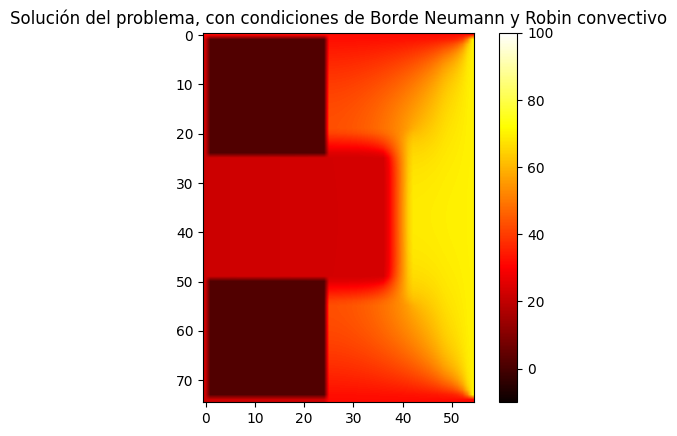

In [35]:

cmap = plt.cm.get_cmap("hot")

image = u
#plt.imshow(image ,cmap="hot")
#plt.imshow(image,vmin=0,vmax=100 ,cmap="hot")
plt.imshow(image,interpolation='bilinear',vmin=-10,vmax=100 ,cmap="hot")
plt.colorbar()
plt.title('Solución del problema, con condiciones de Borde Neumann y Robin convectivo')
plt.show()